# Smile Detector

Remember the "Happy House" Exercise from Coursera?
The task was to build a image classificator, which can decide wether a person is smiling or not (since in the 'Happy House' only happy people are allowed to enter).

If you don't know the exercise, see:

https://www.kaggle.com/iarunava/happy-house-dataset

https://github.com/Kulbear/deep-learning-coursera/blob/master/Convolutional%20Neural%20Networks/Keras%20-%20Tutorial%20-%20Happy%20House%20v1.ipynb

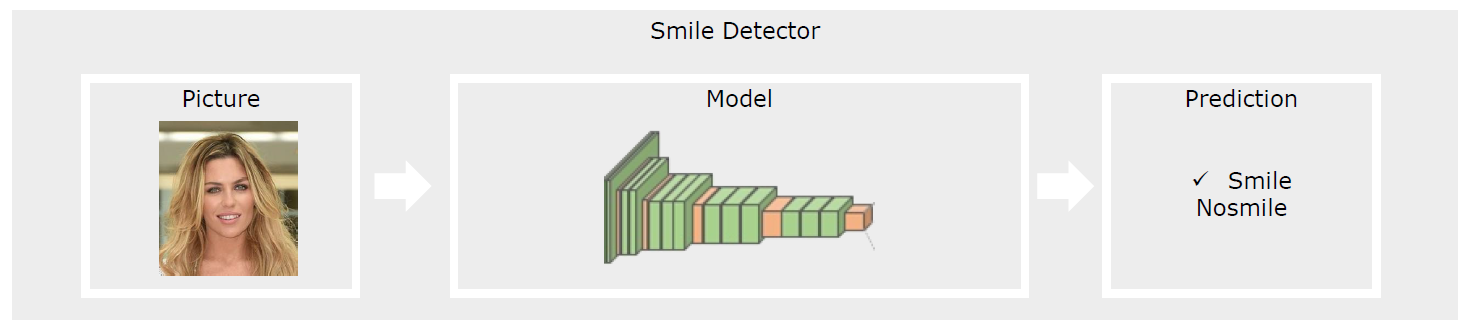

In [5]:
from IPython.display import Image, display
display(Image(filename='nb_images/1_task.png', embed=True))


In the Coursera Keras tutorial, a smile detection accuracy of around 90 percent is achieved.

This notebook shows an improved implementation in Keras. In that, I show how the accuracy can be signifficantly improved by using a larger training dataset and reusing pretrained convolutional neural networks.

## Gathering the training dataset

A crucial step to develop great deep learning models is to gather a good training dataset.
Since this task is to detect wether a person is smiling, we need a dataset with pictures of faces where a person is either smiling or not.
Unfortunately, there is no such large training dataset, so we have to gather it on our own.

The VGG face dataset is a good basis. It contains a large collection of pictures of faces.
http://www.robots.ox.ac.uk/~vgg/data/vgg_face/

I have taken 800 pictures from this dataset and sorted them into smiling or not-smiling (400 smiling, 400 not-smiling). Out of these 800 pictures, I have set 100 pictures aside for testing purposes (700 training pictures, 100 testing pictures).

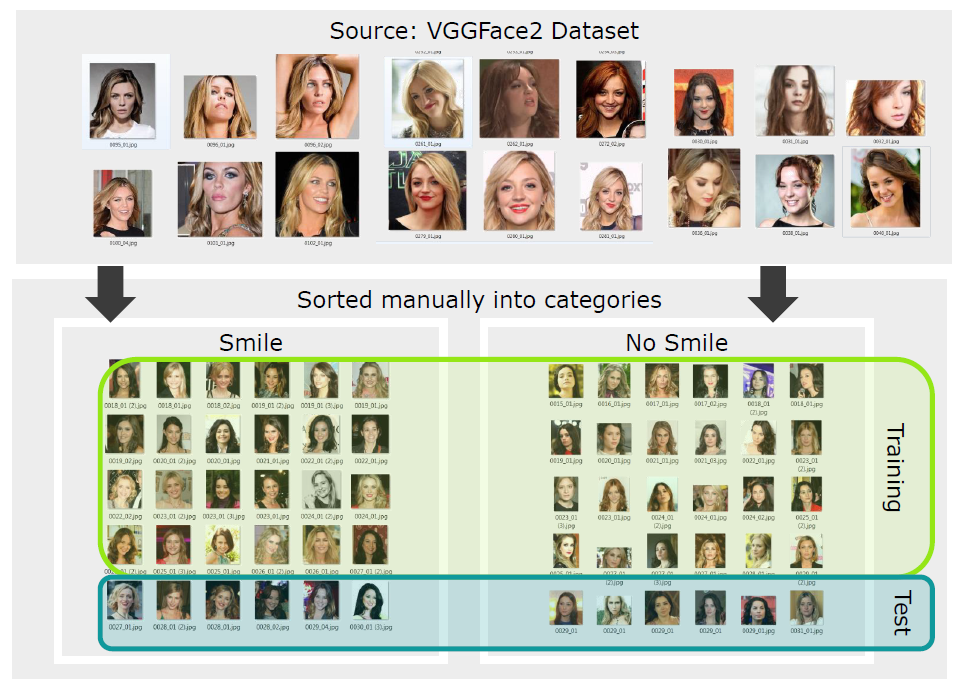

In [6]:
display(Image(filename='nb_images/2_dataset.png', embed=True))

The nice thing in the VGG face dataset is, that the pictures are already cropped. Here, you can see that if we apply an object detection, that the pictures are cropped pretty well (I have used an inception v2 mask CNN and the tensorflow object localization API).

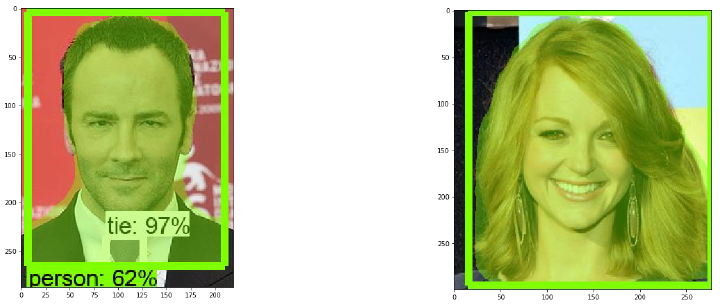

In [7]:
display(Image(filename='nb_images/3_dataset_crop.png', embed=True))

I hope you have gained a good understanding about the task and the dataset, let's continue with the code

## Libraries

As in the original coursera task, I will use Keras.

In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import numpy as np
from numpy import genfromtxt

from scipy.misc import imread, imresize

import tensorflow as tf

from keras import backend as K
from keras import applications
from keras import optimizers

from keras.models import Model, Sequential, load_model

from keras.preprocessing.image import image, ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.layers import Dropout, Flatten, Dense, Conv2D, ZeroPadding2D, MaxPooling2D, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.initializers import glorot_uniform
from keras.engine.topology import Layer



Using TensorFlow backend.


## Settings

Here you can set settings for the training

In [11]:
# image dimensions
img_width, img_height = 150, 150

train_data_dir = 'image_data/train'
validation_data_dir = 'image_data/validation'

nr_train_samples = 700
nr_validation_samples = 100

epochs = 30
batch_size = 10

# important: the image input data must be formated according to the data 
# format in Keras (which could change depending on settings and backend)
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

For easier training, I will use a couple of callbacks.

In [12]:
# early stopping prevents the model from training to long without improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# I want to save the best model as a checkpoint
checkpoint_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# furthermore, it can be sensible to reduce the learning rate
# after training is at an plateau
# reduce_lr_loss_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
callbacks=[early_stopping, checkpoint_save]


## Data loading

In this section, I specify how the images are loaded and processed (e.g. rescaled) in Keras.

To increase the variation in the training data, I have included an ImageDataGenerator which uses augmentation, as you can see here:

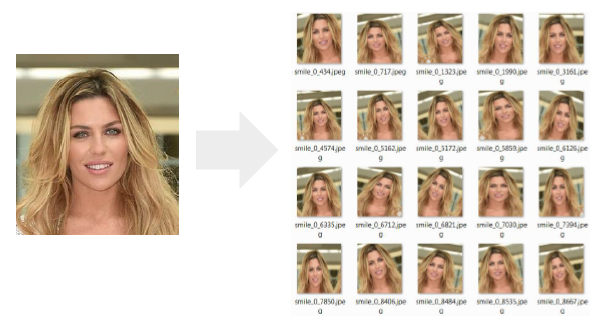

In [8]:
display(Image(filename='nb_images/4_augmentation.png', embed=True))

In [3]:
# this is the augmentation configuration we will use for training
train_datagen_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1. / 255,
    horizontal_flip=True,
    fill_mode='reflect')

# or, without augmentation:
train_datagen_no_aug = ImageDataGenerator(rescale=1. / 255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

#train_generator = train_datagen.flow_from_directory(
train_generator = train_datagen_no_aug.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 700 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## Models

In contrast to the original 'Happy House' model and solution, I have chosen to customize pretrained Models. In that, I reuse the convolutional layers and add custom dense layers.

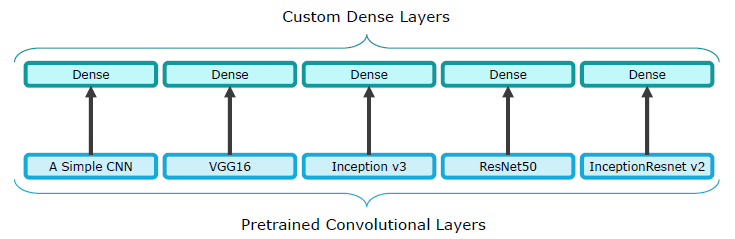

In [9]:
display(Image(filename='nb_images/5_models.png', embed=True))

In [3]:
def get_inception_v3():
    bottom_model = applications.InceptionV3(weights='imagenet', include_top=False,  input_shape=input_shape)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=bottom_model.output_shape[1:]))
    top_model.add(Dense(1, activation='sigmoid'))
    model = Model(inputs=bottom_model.input, outputs=top_model(bottom_model.output))
    return model

def get_inception_resnet_v2():
    bottom_model = applications.InceptionResNetV2(weights='imagenet', include_top=False,  input_shape=input_shape)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=bottom_model.output_shape[1:]))
    top_model.add(Dense(1, activation='sigmoid'))
    model = Model(inputs=bottom_model.input, outputs=top_model(bottom_model.output))
    return model

def get_resnet_50():
    bottom_model = applications.ResNet50(weights='imagenet', include_top=False,  input_shape=input_shape)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=bottom_model.output_shape[1:]))
    top_model.add(Dense(1, activation='sigmoid'))
    model = Model(inputs=bottom_model.input, outputs=top_model(bottom_model.output))
    return model
    
def get_simplified_vgg16():
    bottom_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    print("Model output shape")
    print(bottom_model.output_shape)
    print("model.output_shape[1:]")
    print(bottom_model.output_shape[1:])
    
    # because for smile detection there are fewer classes and training data
    # than imagenet, I will add a smaller dense layer
    # as recommended by Francoise Chollet in his book
    top_model = Sequential()
    top_model.add(Flatten(input_shape=bottom_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    model = Model(inputs=bottom_model.input, outputs=top_model(bottom_model.output))

    return model
    
# this model is similar to the simple CNN model used by Francois Chollet
# in his deep learning book
def get_simple_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # since this model is not pretrained, no layers are frozen
    return model

# for inception, use faceRecoModel function from inception_blocks_v2.py
def get_inception_model(input_shape):
    input_shape=(3, 96, 96)
    model =  faceRecoModel(input_shape)
    # compile FR model and load weights (from fr_utils)
    model.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
    load_weights_from_FaceNet(model)
    return model


## Augmentation Test

In [2]:
# this function can be used to sample variations of an image
# like the one above where I explain augmentation
def test_augmentation():
    datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            rescale=1. / 255,
            horizontal_flip=True,
            fill_mode='reflect')  # nearest')

    img = load_img('image_data/train/smile/0014_01.jpg') 
    x = img_to_array(img) # convert PIL to numpy array
    x = x.reshape((1,) + x.shape)  # transform shape to (1, 3, 150, 150)

    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='augmentation_preview', save_prefix='smile', save_format='jpeg'):
        i += 1
        if i > 20:
            break  # run for 20 iterations
            

# Testing various Models

Here I test various model architectures

# Model 1: Simple CNN

In [6]:
model = get_simple_cnn()
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nr_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nr_validation_samples // batch_size,
    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
70/70 [==============================] - 13s 183ms/step - loss: 0.7518 - acc: 0.5000 - val_loss: 0.6965 - val_acc: 0.5000
Epoch 2/30
70/70 [==============================] - 11s 163ms/step - loss: 0.7023 - acc: 0.5271 - val_loss: 0.6918 - val_acc: 0.5900
Epoch 3/30
70/70 [==============================] - 12s 168ms/step - loss: 0.6865 - acc: 0.5900 - val_loss: 0.6638 - val_acc: 0.6500
Epoch 4/30
70/70 [==============================] - 11s 161ms/step - loss: 0.6374 - acc: 0.6814 - val_loss: 0.5783 - val_acc: 0.6800
Epoch 5/30
70/70 [==============================] - 11s 163ms/step - loss: 0.5007 - acc: 0.7814 - val_loss: 0.5012 - val_acc: 0.8000
Epoch 6/30
70/70 [==============================] - 11s 157ms/step - loss: 0.3683 - acc: 0.8386 - val_loss: 0.3795 - val_acc: 0.8100
Epoch 7/30
70/70 [==============================] - 11s 163ms/step - loss: 0.2883 - acc: 0.8814 - val_loss: 0.4033 - val_acc: 0.8100
Epoch 8/30
70/70 [===

## Model 2: VGG16

In [8]:
model = get_simplified_vgg16()

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


Model output shape
(None, 4, 4, 512)
model.output_shape[1:]
(4, 4, 512)


In [9]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nr_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nr_validation_samples // batch_size,
    callbacks=callbacks)

Epoch 1/30
70/70 [==============================] - 313s 4s/step - loss: 8.0695 - acc: 0.4943 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/30
70/70 [==============================] - 300s 4s/step - loss: 8.0130 - acc: 0.5029 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/30
70/70 [==============================] - 300s 4s/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/30
70/70 [==============================] - 299s 4s/step - loss: 8.0360 - acc: 0.5014 - val_loss: 8.3814 - val_acc: 0.4800
Epoch 5/30
70/70 [==============================] - 300s 4s/step - loss: 7.9669 - acc: 0.5057 - val_loss: 7.8979 - val_acc: 0.5100
Epoch 6/30
70/70 [==============================] - 303s 4s/step - loss: 8.2893 - acc: 0.4857 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 7/30
70/70 [==============================] - 307s 4s/step - loss: 7.9439 - acc: 0.5071 - val_loss: 7.8979 - val_acc: 0.5100
Epoch 8/30
70/70 [==============================] - 300s 4s/step - loss: 7.9900 - a

## Model 3: Inception v3

In [10]:
model = get_inception_v3()

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [11]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nr_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nr_validation_samples // batch_size,
    callbacks=callbacks)

Epoch 1/30
70/70 [==============================] - 132s 2s/step - loss: 0.7573 - acc: 0.7543 - val_loss: 3.5385 - val_acc: 0.6200
Epoch 2/30
70/70 [==============================] - 109s 2s/step - loss: 1.0026 - acc: 0.8757 - val_loss: 6.9035 - val_acc: 0.4900
Epoch 3/30
70/70 [==============================] - 110s 2s/step - loss: 0.4120 - acc: 0.9400 - val_loss: 4.1850 - val_acc: 0.6900
Epoch 4/30
70/70 [==============================] - 108s 2s/step - loss: 0.4072 - acc: 0.9243 - val_loss: 8.6089 - val_acc: 0.4600
Epoch 5/30
70/70 [==============================] - 109s 2s/step - loss: 0.3183 - acc: 0.9271 - val_loss: 3.9895 - val_acc: 0.7500
Epoch 6/30
70/70 [==============================] - 109s 2s/step - loss: 0.6813 - acc: 0.9271 - val_loss: 7.0171 - val_acc: 0.5300
Epoch 7/30
70/70 [==============================] - 110s 2s/step - loss: 0.7812 - acc: 0.9371 - val_loss: 2.0613 - val_acc: 0.8500
Epoch 8/30
70/70 [==============================] - 109s 2s/step - loss: 0.6415 - a

## Model 4: Resnet50

In [12]:
model = get_resnet_50()

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

C:\Users\jgontare\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [13]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nr_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nr_validation_samples // batch_size,
    callbacks=callbacks)

Epoch 1/30
70/70 [==============================] - 217s 3s/step - loss: 8.0259 - acc: 0.4957 - val_loss: 9.3485 - val_acc: 0.4200
Epoch 2/30
70/70 [==============================] - 199s 3s/step - loss: 5.4730 - acc: 0.5157 - val_loss: 7.7367 - val_acc: 0.5200
Epoch 3/30
70/70 [==============================] - 200s 3s/step - loss: 2.0635 - acc: 0.6200 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/30
70/70 [==============================] - 200s 3s/step - loss: 1.3142 - acc: 0.7386 - val_loss: 6.2821 - val_acc: 0.5400
Epoch 5/30
70/70 [==============================] - 201s 3s/step - loss: 2.1090 - acc: 0.5471 - val_loss: 9.1873 - val_acc: 0.4300
Epoch 6/30
70/70 [==============================] - 201s 3s/step - loss: 1.5781 - acc: 0.7414 - val_loss: 8.3691 - val_acc: 0.4800
Epoch 7/30
70/70 [==============================] - 199s 3s/step - loss: 1.8072 - acc: 0.6371 - val_loss: 6.6150 - val_acc: 0.5200
Epoch 8/30
70/70 [==============================] - 200s 3s/step - loss: 1.4240 - a

## Model 5: InceptionResnetV2

In [14]:
model = get_inception_resnet_v2()

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [15]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nr_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nr_validation_samples // batch_size,
    callbacks=callbacks)

Epoch 1/30
70/70 [==============================] - 347s 5s/step - loss: 1.4342 - acc: 0.7657 - val_loss: 1.2755 - val_acc: 0.7500
Epoch 2/30
70/70 [==============================] - 251s 4s/step - loss: 1.0308 - acc: 0.8771 - val_loss: 7.9015 - val_acc: 0.5100
Epoch 3/30
70/70 [==============================] - 254s 4s/step - loss: 0.3687 - acc: 0.9443 - val_loss: 0.1705 - val_acc: 0.9900
Epoch 4/30
70/70 [==============================] - 252s 4s/step - loss: 0.1403 - acc: 0.9600 - val_loss: 2.1470 - val_acc: 0.8400
Epoch 5/30
70/70 [==============================] - 248s 4s/step - loss: 0.0345 - acc: 0.9886 - val_loss: 0.5160 - val_acc: 0.9000
Epoch 6/30
70/70 [==============================] - 250s 4s/step - loss: 0.1965 - acc: 0.9700 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 7/30
70/70 [==============================] - 249s 4s/step - loss: 0.0119 - acc: 0.9957 - val_loss: 3.8467e-04 - val_acc: 1.0000
Epoch 8/30
70/70 [==============================] - 249s 4s/step - loss: 0.0773

## Predict for one single image

This function can be used to predict for an image, if the person is smiling or not.

In [18]:
def prepare_image(filename):
    img = image.load_img(filename, target_size=(img_width, img_height))
    img = image.img_to_array(img) # convert to numpy array
    img = img.reshape((1,) + img.shape) # reshape
    img = img/255 # rescale
    return img

print(model.predict(prepare_image('image_data/validation/smile/0020_02.jpg')))

print(model.predict(prepare_image('image_data/validation/nosmile/0046_01.jpg')))

[[1.]]
[[3.6297257e-24]]


# Conclusion

By using a new training dataset with 700 images, we can get a similar result as the original approach when using a simple, not-pretrained CNN, although the dataset has a larger number of different faces.

When using more complex and pretrained networks, the accuracy can improve even further to close to 100 % accuracy on the testing data.
This shows, that reusing complex and pretrained CNNs can improve accuracy of our image classification tasks greatly.

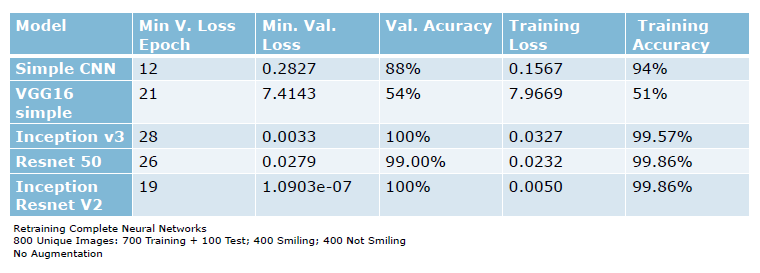

In [10]:
display(Image(filename='nb_images/6_results.png', embed=True))